In [1]:
import numpy as np
from keras.utils import to_categorical
from keras.datasets import cifar10
import tensorflow as tf
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
# import pydot
# from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.initializers import glorot_uniform
import scipy.misc
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model, Model
from matplotlib.pyplot import imshow
from keras.layers.noise import GaussianNoise
from keras.layers.normalization import BatchNormalization
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)
import time, pickle

Using TensorFlow backend.


# 输入数据

In [2]:
nb_classes = 10
class_name = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck',
}

In [3]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [4]:
y_train = y_train.reshape(y_train.shape[0])
y_test = y_test.reshape(y_test.shape[0])

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'training samples')
print(X_test.shape[0], 'validation samples')

X_train shape: (50000, 32, 32, 3)
50000 training samples
10000 validation samples


# 标准化

In [5]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

# 分类

In [6]:
y_train = to_categorical(y_train, nb_classes)
y_test = to_categorical(y_test, nb_classes)

# 模型

In [7]:
# GRADED FUNCTION: identity_block

def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = "res" + str(stage) + block + "_branch"
    bn_name_base   = "bn"  + str(stage) + block + "_branch"
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding="valid", 
               name=conv_name_base+"2a", kernel_initializer=glorot_uniform(seed=0))(X)
    #valid mean no padding / glorot_uniform equal to Xaiver initialization - Steve 
    
    X = BatchNormalization(axis=3, name=bn_name_base + "2a")(X)
    X = Activation("relu")(X)
    ### START CODE HERE ###
    
    # Second component of main path (≈3 lines)
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding="same",
               name=conv_name_base+"2b", kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base+"2b")(X)
    X = Activation("relu")(X)
    # Third component of main path (≈2 lines)


    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding="valid",
               name=conv_name_base+"2c", kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base+"2c")(X)
    
    X = Add()([X, X_shortcut])
    X = Activation("relu")(X)
    ### END CODE HERE ###
    
    return X


In [8]:
# GRADED FUNCTION: convolutional_block

def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', padding='valid', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    ### START CODE HERE ###

    # Second component of main path (≈3 lines)
    X = Conv2D(F2, (f, f), strides = (1, 1), name = conv_name_base + '2b',padding='same', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(F3, (1, 1), strides = (1, 1), name = conv_name_base + '2c',padding='valid', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv2D(F3, (1, 1), strides = (s, s), name = conv_name_base + '1',padding='valid', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = layers.add([X, X_shortcut])
    X = Activation('relu')(X)
    
    ### END CODE HERE ###
    
    return X


In [9]:
# GRADED FUNCTION: ResNet50

def ResNet50(input_shape = (32, 32, 3), classes = 10):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(filters=64, kernel_size=(7, 7), strides=(2, 2), name="conv",
               kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name="bn_conv1")(X)
    X = Activation("relu")(X)
    X = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block="a", s=1)
    X = identity_block(X, f=3, filters=[64, 64, 256], stage=2, block="b")
    X = identity_block(X, f=3, filters=[64, 64, 256], stage=2, block="c")
    ### START CODE HERE ###

    # Stage 3 (≈4 lines)
    # The convolutional block uses three set of filters of size [128,128,512], "f" is 3, "s" is 2 and the block is "a".
    # The 3 identity blocks use three set of filters of size [128,128,512], "f" is 3 and the blocks are "b", "c" and "d".
    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block="a", s=1)
    X = identity_block(X, f=3, filters=[128, 128, 512], stage=3, block="b")
    X = identity_block(X, f=3, filters=[128, 128, 512], stage=3, block="c")
    X = identity_block(X, f=3, filters=[128, 128, 512], stage=3, block="d")
    
    # Stage 4 (≈6 lines)
    # The convolutional block uses three set of filters of size [256, 256, 1024], "f" is 3, "s" is 2 and the block is "a".
    # The 5 identity blocks use three set of filters of size [256, 256, 1024], "f" is 3 and the blocks are "b", "c", "d", "e" and "f".
    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block="a", s=2)
    X = identity_block(X, f=3, filters=[256, 256, 1024], stage=4, block="b")
    X = identity_block(X, f=3, filters=[256, 256, 1024], stage=4, block="c")
    X = identity_block(X, f=3, filters=[256, 256, 1024], stage=4, block="d")
    X = identity_block(X, f=3, filters=[256, 256, 1024], stage=4, block="e")
    X = identity_block(X, f=3, filters=[256, 256, 1024], stage=4, block="f")
    

    # Stage 5 (≈3 lines)
    # The convolutional block uses three set of filters of size [512, 512, 2048], "f" is 3, "s" is 2 and the block is "a".
    # The 2 identity blocks use three set of filters of size [256, 256, 2048], "f" is 3 and the blocks are "b" and "c".
    X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block="a", s=2)
    X = identity_block(X, f=3, filters=[512, 512, 2048], stage=5, block="b")
    X = identity_block(X, f=3, filters=[512, 512, 2048], stage=5, block="c")
    
    # filters should be [256, 256, 2048], but it fail to be graded. Use [512, 512, 2048] to pass the grading
    

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    # The 2D Average Pooling uses a window of shape (2,2) and its name is "avg_pool".
    X = AveragePooling2D(pool_size=(2, 2), padding="same")(X)
    
    ### END CODE HERE ###

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation="softmax", name="fc"+str(classes), kernel_initializer=glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs=X_input, outputs=X, name="ResNet50")

    return model


In [10]:
# SGD (Stochastic Gradient Descent)
# lrate = 0.01
# decay = lrate / nb_epoch
# sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)

model = ResNet50(input_shape=(32, 32, 3), classes=10)

model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 38, 38, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv (Conv2D)                   (None, 16, 16, 64)   9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 16, 16, 64)   256         conv[0][0]                       
__________________________________________________________________________________________________
activation

In [11]:
nb_epoch = 100
batch_size = 256
start = time.time()
h = model.fit(x=X_train, y=y_train, batch_size=batch_size, epochs=nb_epoch, validation_data=(X_test, y_test), shuffle=True)
model1.save('CIFAR10_RESNET.h5')
print('@ Total Time Spent: %.2f seconds' % (time.time() - start))

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
 5376/50000 [==>...........................] - ETA: 1:47 - loss: 2.6386 - acc: 0.2001

KeyboardInterrupt: 

In [26]:
loss, accuracy = model1.evaluate(X_train, y_train, verbose=0)
print("Training Accuracy = %.2f %%     loss = %f" % (accuracy * 100, loss))
loss, accuracy = model1.evaluate(X_test, y_test, verbose=0)
print("Testing Accuracy = %.2f %%    loss = %f" % (accuracy * 100, loss))

Training Accuracy = 91.71 %     loss = 0.271496
Testing Accuracy = 76.79 %    loss = 0.733290


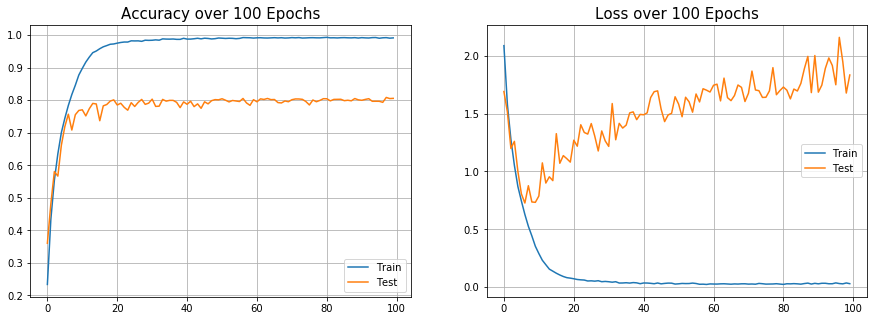

In [27]:
def plot_acc_loss(h, nb_epoch):
    acc, loss, val_acc, val_loss = h.history['acc'], h.history['loss'], h.history['val_acc'], h.history['val_loss']
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    plt.plot(range(nb_epoch), acc, label='Train')
    plt.plot(range(nb_epoch), val_acc, label='Test')
    plt.title('Accuracy over ' + str(nb_epoch) + ' Epochs', size=15)
    plt.legend()
    plt.grid(True)
    plt.subplot(122)
    plt.plot(range(nb_epoch), loss, label='Train')
    plt.plot(range(nb_epoch), val_loss, label='Test')
    plt.title('Loss over ' + str(nb_epoch) + ' Epochs', size=15)
    plt.legend()
    plt.grid(True)
    plt.show()
    
plot_acc_loss(h, nb_epoch)